In [1]:
from datetime import date 
import tempfile
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import pandas as pd
import math
from astropy.io import fits
from astropy.time import Time
from astropy import wcs
temp_dir = tempfile.TemporaryDirectory()
import math
import os
import random
import time
from math import pi
from random import choices
from time import gmtime, strftime
from typing import Optional
import astropy.constants as C
import astropy.units as U
import h5py
import nifty8 as ift
from astropy.constants import c
import astropy.cosmology.units as cu
from astropy.cosmology import Planck13
from astropy.time import Time
from astropy.wcs import WCS
import pyvo
from scipy.optimize import curve_fit

In [2]:
def query_observations(service, member_ous_uid, target_name):
    """Query for all science observations of given member OUS UID and target name, selecting all columns of interest.

    Parameters:
    service (pyvo.dal.TAPService): A TAPService instance for querying the database.
    member_ous_uid (str): The unique identifier for the member OUS to filter observations by.
    target_name (str): The target name to filter observations by.

    Returns:
    pandas.DataFrame: A table of query results.
    """

    query = f"""
            SELECT *
            FROM ivoa.obscore
            WHERE member_ous_uid = '{member_ous_uid}'
            AND target_name = '{target_name}'
            AND is_mosaic = 'F'
            """

    result = service.search(query).to_table().to_pandas()

    return result

In [3]:
def get_science_types(service):
    query = f"""  
            SELECT science_keyword, scientific_category  
            FROM ivoa.obscore  
            WHERE science_observation = 'T'    
            """
    db = service.search(query).to_table().to_pandas()
    science_keywords = db['science_keyword'].unique()
    scientific_category = db['scientific_category'].unique()
    science_keywords = list(filter(lambda x: x != "", science_keywords))
    scientific_category = list(filter(lambda x: x != "", scientific_category))
    return  science_keywords, scientific_category

In [4]:
def query_all_targets(service, targets):
    """Query observations for all predefined targets and compile the results into a single DataFrame.

    Parameters:
    service (pyvo.dal.TAPService): A TAPService instance for querying the database.
    targets (list of tuples): A list where each tuple contains (target_name, member_ous_uid).

    Returns:
    pandas.DataFrame: A DataFrame containing the results for all queried targets.
    """
    results = []

    for target_name, member_ous_uid in targets:
        result = query_observations(service, member_ous_uid, target_name)
        results.append(result)

    # Concatenate all DataFrames into a single DataFrame
    df = pd.concat(results, ignore_index=True)

    return df

In [5]:
def query_for_metadata_by_targets(targets, path, service_url: str = "https://almascience.eso.org/tap"):
    """Query for metadata for all predefined targets and compile the results into a single DataFrame.

    Parameters:
    service_url (str): A TAPService http address for querying the database.
    targets (list of tuples): A list where each tuple contains (target_name, member_ous_uid).
    path (str): The path to save the results to.

    Returns:
    pandas.DataFrame: A DataFrame containing the results for all queried targets.
    """
    # Create a TAPService instance (replace 'your_service_url' with the actual URL)
    service = pyvo.dal.TAPService(service_url)
    # Query all targets and compile the results
    df = query_all_targets(service, targets)
    df = df.drop_duplicates(subset='member_ous_uid')
    # Define a dictionary to map existing column names to new names with unit initials
    rename_columns = {
    'target_name': 'ALMA_source_name',
    'pwv': 'PWV',
    'schedblock_name': 'SB_name',
    'velocity_resolution': 'Vel.res.',
    'spatial_resolution': 'Ang.res.',
    's_ra': 'RA',
    's_dec': 'Dec',
    's_resolution': 'Spatial.resolution',
    's_fov': 'FOV',
    't_resolution': 'Int.Time',
    't_max': 'Total.Time',
    'cont_sensitivity_bandwidth': 'Cont_sens_mJybeam',
    'sensitivity_10kms': 'Line_sens_10kms_mJybeam',
    'obs_release_date': 'Obs.date',
    'band_list': 'Band',
    'bandwidth': 'Bandwidth',
    'frequency': 'Freq',
    'frequency_support': 'Freq.support',

    }
    # Rename the columns in the DataFrame
    df.rename(columns=rename_columns, inplace=True)
    database = df[['ALMA_source_name', 'Band', 'PWV', 'SB_name', 'Vel.res', 'Ang.res', 'RA', 'Dec', 'FOV', 'Int.Time', 
                    'Total.Time', 'Cont_sens_mJybeam', 'Line_sens_10kms_mJybeam', 'Obs.date', 'Bandwidth', 'Freq', 
                    'Freq.support', 'Spatial.resolution']]
    database = database[database['Obs.date'] <= '2024-9-30']
    database['Obs.date'] = database['Obs.date'].apply(lambda x: x.split('T')[0])
    database.to_csv(path, index=False)
    return database

In [6]:
def query_by_science_type(service, science_keyword=None, scientific_category=None):
    """Query for all science observations of given member OUS UID and target name, selecting all columns of interest.

    Parameters:
    service (pyvo.dal.TAPService): A TAPService instance for querying the database.

    Returns:
    pandas.DataFrame: A table of query results.
    """
    if science_keyword == None:
        science_keyword = ""
    if scientific_category == None:
        scientific_category = ""
    print('Querying for science keyword/s: ', science_keyword)
    print('And scientific category/ies: ', scientific_category)
    if type(science_keyword) == list and len(science_keyword) == 1:
        science_keyword = science_keyword[0]
        science_keyword_query = f"science_keyword like '%{science_keyword}%'"
    elif type(science_keyword) == list and len(science_keyword) > 1:
        science_keyword = "', '".join(science_keyword)
        science_keyword_query = f"science_keyword in ('{science_keyword}')"
    else:
        science_keyword_query = f"science_keyword like '%{science_keyword}%'"
    if type(scientific_category) == list and len(scientific_category) == 1:
        scientific_category = scientific_category[0]
        scientific_category_query = f"scientific_category like '%{scientific_category}%'"
    elif type(scientific_category) == list and len(scientific_category) > 1:
        scientific_category = "', '".join(scientific_category)
        scientific_category_query = f"scientific_category in ('{scientific_category}')"
    else:
        scientific_category_query = f"scientific_category like '%{scientific_category}%'"


    query = f"""
            SELECT *
            FROM ivoa.obscore
            WHERE {science_keyword_query}
            AND {scientific_category_query}
            AND is_mosaic = 'F'
            """

    result = service.search(query).to_table().to_pandas()

    return result


In [7]:
def query_for_metadata_by_science_type(path, service_url: str = "https://almascience.eso.org/tap"):
    service = pyvo.dal.TAPService(service_url)
    science_keywords, scientific_categories = get_science_types(service)
    print('Available science keywords:')
    for i in range(len(science_keywords)):
        print(f'{i}: {science_keywords[i]}')
    print('Available scientific categories:')
    for i in range(len(scientific_categories)):
        print(f'{i}: {scientific_categories[i]}')
    science_keyword_number = input('Plese select the Science Keyword by number, if you want to select multiple numbers separate them by a space, leave empty for all:' )
    scientific_category_number = input('Plese select the Scientific Category by number, if you want to select multiple numbers separate them by a space, leave empty for all:' )
    if science_keyword_number == "":
        science_keyword = None
    else:
        science_keyword_number = [int(x) for x in science_keyword_number.split(' ')]
        science_keyword = [science_keywords[i] for i in science_keyword_number]
    if scientific_category_number == "":
        scientific_category = None
    else:
        scientific_category_number = [int(x) for x in scientific_category_number.split(' ')]
        scientific_category = [scientific_categories[i] for i in scientific_category_number]
    df = query_by_science_type(service, science_keyword, scientific_category)
    df = df.drop_duplicates(subset='member_ous_uid')
    
    # Define a dictionary to map existing column names to new names with unit initials
    rename_columns = {
    'target_name': 'ALMA_source_name',
    'pwv': 'PWV',
    'schedblock_name': 'SB_name',
    'velocity_resolution': 'Vel.res.',
    'spatial_resolution': 'Ang.res.',
    's_ra': 'RA',
    's_dec': 'Dec',
    's_fov': 'FOV',
    't_resolution': 'Int.Time',
    't_max': 'Total.Time',
    'cont_sensitivity_bandwidth': 'Cont_sens_mJybeam',
    'sensitivity_10kms': 'Line_sens_10kms_mJybeam',
    'obs_release_date': 'Obs.date',
    'band_list': 'Band',
    'bandwidth': 'Bandwidth',
    'frequency': 'Freq',
    'frequency_support': 'Freq.sup.'

    }
    # Rename the columns in the DataFrame
    df.rename(columns=rename_columns, inplace=True)
    database = df[['ALMA_source_name', 'Band', 'PWV', 'SB_name', 'Vel.res.', 'Ang.res.', 'RA', 'Dec', 'FOV', 'Int.Time', 
                    'Total.Time', 'Cont_sens_mJybeam', 'Line_sens_10kms_mJybeam', 'Obs.date', 'Bandwidth', 'Freq', 
                    'Freq.sup.', 'antenna_arrays']]
    database['Obs.date'] = database['Obs.date'].apply(lambda x: x.split('T')[0])
    database.to_csv(path, index=False)
    return database


In [8]:
parent_dir = os.path.dirname(os.getcwd())
metadata = query_for_metadata_by_science_type(os.path.join(parent_dir, 'metadata', 'Active_galaxies_metadata.csv'))

Available science keywords:
0: Lyman Break Galaxies (LBG), Sub-mm Galaxies (SMG)
1: The Sun
2: Astrochemistry
3: High-z Active Galactic Nuclei (AGN), Galaxy structure & evolution
4: Outflows, jets, feedback
5: Active Galactic Nuclei (AGN)/Quasars (QSO), Outflows, jets, feedback
6: Exo-planets
7: Outflows, jets, feedback, Galactic centres/nuclei
8: Active Galactic Nuclei (AGN)/Quasars (QSO), Galactic centres/nuclei
9: Spiral galaxies
10: Active Galactic Nuclei (AGN)/Quasars (QSO)
11: Disks around low-mass stars
12: Starburst galaxies, Gravitational lenses
13: Starburst galaxies, Galaxy structure & evolution
14: Starburst galaxies
15: Main sequence stars
16: Low-mass star formation
17: Damped Lyman Alpha (DLA) systems, Galaxy structure & evolution
18: Disks around low-mass stars, Exo-planets
19: Inter-Stellar Medium (ISM)/Molecular clouds
20: Inter-Stellar Medium (ISM)/Molecular clouds, Photon-Dominated Regions (PDR)/X-Ray Dominated Regions (XDR)
21: Brown dwarfs
22: Starbursts, star for

C:\Users\lsann\AppData\Local\Temp\ipykernel_9220\3089593618.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  database['Obs.date'] = database['Obs.date'].apply(lambda x: x.split('T')[0])


In [9]:
metadata.info

<bound method DataFrame.info of       ALMA_source_name Band       PWV                   SB_name      Vel.res.  \
0                Titan    7  1.105334          NGC_5765_b_07_TE    531.778528   
4           J1550+0527    7  0.624941          NGC_5765_a_07_TE    538.247383   
12             IC_2560    7  0.859246           IC_2560_a_07_TE    528.997732   
28          J0538-4405    7  0.719710          ESO_558-_a_07_TE    537.417879   
52          J1256-0547    7  0.642765           IC_2560_b_07_TE    522.699851   
...                ...  ...       ...                       ...           ...   
41644       J1427-4206    7  1.042373         Sgr_A_st_b_07_TM1  53611.779080   
41660       J1427-4206    7  1.019980         Sgr_A_st_a_07_TM1  53611.779080   
41676       J1517-2422    7  1.029737         FRB19052_a_07_TM1   8375.744134   
41692       J1751+0939    6  3.118386       e24b04_M87_b_06_TM1   2534.510401   
41744       J1256-0547    6  2.242681  e24b04_SgrA_sta_b_06_TM1   2534.510401

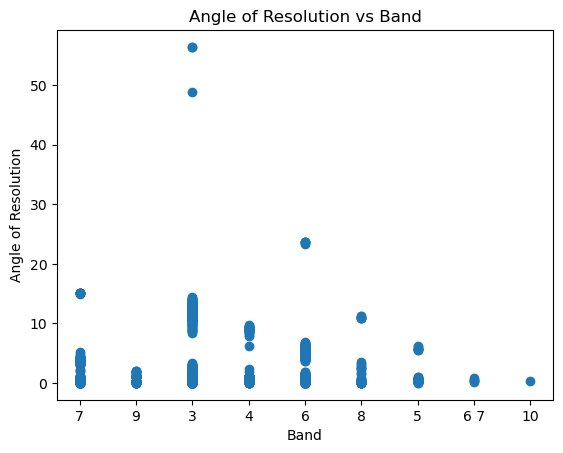

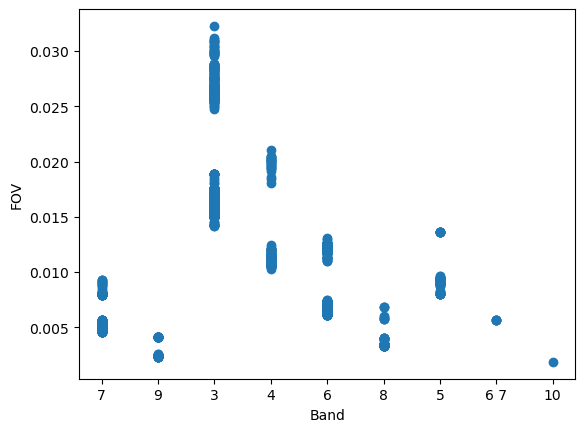

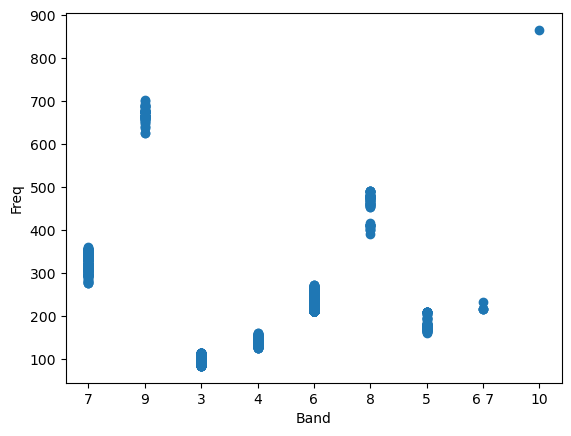

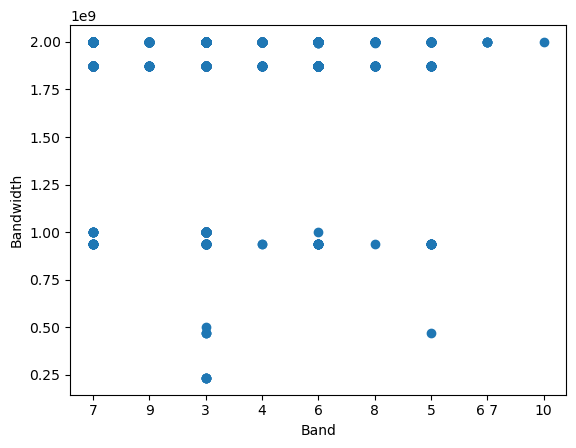

Index(['ALMA_source_name', 'Band', 'PWV', 'SB_name', 'Vel.res.', 'Ang.res.',
       'RA', 'Dec', 'FOV', 'Int.Time', 'Total.Time', 'Cont_sens_mJybeam',
       'Line_sens_10kms_mJybeam', 'Obs.date', 'Bandwidth', 'Freq', 'Freq.sup.',
       'antenna_arrays'],
      dtype='object')

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('os.path.join(parent_dir, 'metadata', 'Active_galaxies_metadata.csv')
plt.scatter(df['Band'], df['Ang.res.'])
plt.xlabel('Band')
plt.ylabel('Angle of Resolution')
plt.title('Angle of Resolution vs Band')
plt.show()
plt.scatter(df['Band'],df['FOV'])
plt.xlabel('Band')
plt.ylabel('FOV')
plt.show()
plt.scatter(df['Band'],df['Freq'])
plt.xlabel('Band')
plt.ylabel('Freq')
plt.show()
plt.scatter(df['Band'],df['Bandwidth'])
plt.xlabel('Band')
plt.ylabel('Bandwidth')
plt.show()
df.columns